# Reorientation lifetime of vectors

In [1]:
from fishmol import trj, atoms, utils, funcs, style
from cage_data import cage1_info

## Read trajectory file

In [2]:
%%time
cell = cage1_info.cell
traj = trj.Trajectory(timestep = 5, data = "/nobackup/rhtp48/data_ana/cage1-500K.xyz", index = ":", cell = cell)

CPU times: user 2min 12s, sys: 4.57 s, total: 2min 17s
Wall time: 2min 17s


## Vector reorientation dynamics (VRD) of water O-H bonds

In [66]:
import numpy as np
from recordclass import make_dataclass
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from fishmol.utils import to_sublists, update_progress
from fishmol import style
from scipy.optimize import curve_fit
from scipy.integrate import quad
class new_VRD(object):
    """Vector Reorientation Dynamics
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Arguments
    spec : np.array or list of two atoms (two atom groups) that determine the vector
    timestep : the timestep of the vector when using np.array input
    traj : the input Trajectory object
    num : int, length of frames to calculate the reorientation dynamics
    skip : int, frames to skip = skip - 1. Determines the sampling step of the Trajectory, eg. skip = 1, use all frames in the Trajectory: skip = 10, skip 9 frames.
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Returns
    self.results:
    - t: time calculated
    - C_t: the average c_t
    - C_t_error: the error of c_t
    """
    def __init__(self, traj = None, spec = None, timestep = None, num = 2000, sampling = 5, skip = 10):
        results = make_dataclass("Results", "t C_t C_t_error t_fit C_t_fit fit_params plot")
        self.results = results
        self.traj = traj
        self.spec = spec
        self.num = num
        self.sampling = sampling
        self.skip = skip
        if traj is not None:
            self.traj = traj
            self.t_step = traj.timestep
        elif traj is None:
            if isinstance(self.spec, np.ndarray):
                if timestep is not None:
                    self.t_step = timestep
                else:
                    print("VRD created with array of vectors without specifying timestep, using default timestep of 5 fs, please specify the timestep you are using if this is incorrect.")
                    self.t_step = 5
            else:
                raise Exception("Please either specify\n:(i)a Trajectory object and a list of the indices of two atoms\nor\n(ii) a np.array object of vector data and the timestep of the vector data.")
        else:
            raise Exception("Please either specify\n:(i)a Trajectory object and a list of the indices of two atoms\nor\n(ii) a np.array object of vector data and the timestep of the vector data.")
        self.results.t = np.linspace(0, self.t_step * (self.num - 1) / 1000, num = self.num//self.sampling)
    
    def calculate(self, plot = True, l = 3, log_scale = False, fit = False, **kwargs):
        if self.traj is not None:
            if any([self.spec[0] is None, self.spec[1] is None]):
                raise ValueError("Please specify atom groups ")
            else:
                combs = make_comb(*self.spec)
            frame_chunks = to_sublists(self.traj.frames, self.num)[::self.skip]
            # n_select_frames = len(frame_chunks[0])
            dot_products = np.zeros((len(frame_chunks), len(self.results.t), len(combs)))
            
            for i, frame_chunk in enumerate(frame_chunks):
                select = frame_chunk[::self.sampling]
                dot_products[i] = np.asarray([np.diagonal(frame.vecs(combs = combs, absolute = False, normalise = True, mic = True).dot(
                    select[0].vecs(combs = combs, absolute = False, normalise = True, mic = True).T)) for frame in select])
                update_progress(i / len(frame_chunks))
            
        # If the vec is an array of vectors without traj
        else:
            vec_chunks = to_sublists(self.spec, self.num)[::self.skip]
            dot_products = np.zeros((len(frame_chunks), len(self.results.t), len(combs)))
            for i, vec_chunk in len(vec_chunks):
                select = vec_chunk[::self.sampling]
                dot_products[i] = np.asarray([vecs.dot(vec_chunk[0]) / (np.linalg.norm(vecs) * vecs(vec_chunk[0])) for vecs in vec_chunk])
                update_progress(i / len(frame_chunks))

        if l == 1:
            self.results.C_t = dot_products.mean(axis = 0)
            self.results.C_t_error = dot_products.std(axis = 0) / (len(frame_chunks))**0.5
        
        elif l == 2:
            self.results.C_t = ((3 * (dot_products)**2 - 1)/2).mean(axis = 0)
            self.results.C_t_error = ((3 * (dot_products)**2 - 1)/2).std(axis = 0) / (len(frame_chunks))**0.5

        elif l == 3:
            self.results.C_t = ((5 * (dot_products)**3 - 3 * (dot_products.mean(axis = 0)))/2).mean(axis = 0)
            self.results.C_t_error = (((5 * (dot_products)**3 - 3 * (dot_products.mean(axis = 0)))/2)).std(axis = 0) / (len(frame_chunks))**0.5
        
        else:
            raise ValueError("l = 1, 2 or 3")

        def kww_func_fit(x, y, tau = 1, beta = 0.4, maxfev = 10000):
            """
            Fit the data with Kohlrausch-Willliams-Watts equation
            """
            def kww_func(t, tau, beta):
                return np.exp(-(t/tau)**beta)

            params,_ = curve_fit(kww_func, x, y, p0=[tau, beta], maxfev = maxfev)
            x_fit = np.linspace(x.min(), x.max(), num = 200)
            y_fit = kww_func(x_fit, *params)
            print("The fitted KWW function paramters are:\nalpha: {0}, beta: {1}".format(*params))
            return x_fit, y_fit, params
        
        if fit:
            self.results.t_fit = np.linspace(self.results.t.min(), self.results.t.max(), num = 200)
            self.results.C_t_fit = np.zeros((200, self.results.C_t.shape[-1]))
            self.results.fit_params = np.zeros((2, self.results.C_t.shape[-1]))
            for i in range(self.results.C_t.shape[-1]):
                _, self.results.C_t_fit[i], self.results.fit_params[i] = kww_func_fit(self.results.t, self.results.C_t[:, i])
        
        update_progress(1)
        
        # delete temp variable to release some memory
        del frame_chunks, dot_products, select
        
        # Plot the results    
        if plot:
            fig, ax = plt.subplots(figsize = (4.2, 3.6))
            for i in range(self.results.C_t.shape[-1]):
                ax.scatter(self.results.t, self.results.C_t[:, i], **kwargs)
            if fit:
                [ax.plot(self.results.t_fit, self.results.C_t_fit[:, i], color = "#525252", lw = 2) for i in range(self.results.C_t.shape[-1])]
            ax.set_xlabel(r"$t$ (ps)")
            ax.set_ylabel(f"$C^{l}_t$")
            if log_scale:
                plt.semilogy()
            plt.show()
            self.results.plot = fig
            
        return self.results

In [ ]:
water_vrd = new_VRD(traj = traj, spec = [14, [15, 16]], num = 500, sampling = 10, skip = 5)
results = water_vrd.calculate(plot = True, l = 1, fit = True)

Progress: [■■■○○○○○○○○○○○○○○○○○] 13.0%


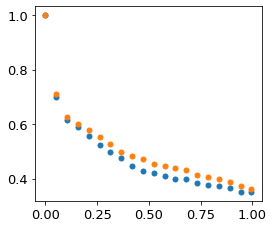

In [27]:
fig, ax = plt.subplots()
for i in range(results.C_t.shape[-1]):
    ax.scatter(results.t, results.C_t[:,i])
# ax.plot(results.t_fit, results.C_t_fit)
plt.show()

## VRD of trifluoroacetate ion C-C bond

In [ ]:
TFAs = cage1_info.TFAs

In [ ]:
spec = [*TFAs[0].values()]
vrd = funcs.VRD(traj = traj, spec = [[spec[-2],], [spec[-1],]], num = 2000, sampling = 5, skip = 2)
results = vrd.calculate(plot = False, l = 3)